# Custom Architecture Research

> Testing varients of an idea to have multiple bodies in a neural net

- toc: true 
- badges: true
- comments: true
- author: Isaac Flath
- categories: [Deep Learning]

This post will cover an architecture modification for training models to give several model bodys feeding into a single custom head.  We will be exploring this in the pets dataset and we see there are some improvements to be had over resnets in this instance.  The goal will be to **predict pet breed**.

>Credit: [David Berger](https://github.com/jdavidberger/) read a previous blog post and had some great ideas for better baselines and things to try.  This post and several of the experiments were largely inspired by our conversation on the fastai discord.

Lets get started!

In [10]:
from fastai.vision.all import *
import pickle

seed = 42

path = untar_data(URLs.PETS)
img = (path/'images').ls()[0]

# The Data

We will start with creating a model for pet breeds and a model for pet species, so we will need dataloaders for each of those models.  I will not cover how this works, but if you would like more details I recommend looking at the fastai datablock tutorial on their documentation page.

We are going to be using **really small images (64x64)** to make this problem hard enough and fast enough to experiment with.

In [5]:
#collapse-hide
def label_func(fname):
    return "cat" if str(fname.name[0]).isupper() else "dog"
def get_dls(get_y):
    pets = DataBlock(
        blocks = (ImageBlock, CategoryBlock),
        get_items = get_image_files,
        splitter= RandomSplitter(valid_pct = 0.2, seed=seed),
        get_y= get_y,
        item_tfms=Resize(128),
        batch_tfms=aug_transforms(min_scale = 0.9,size=64)
    )
    return pets.dataloaders(path/"images",bs=64)

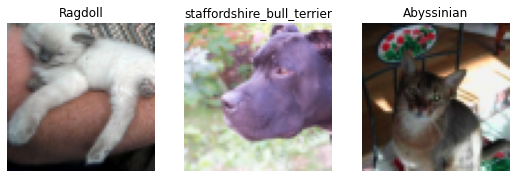

In [6]:
dls_breed = get_dls(using_attr(RegexLabeller(r'(.+)_\d+.jpg$'),'name'))
dls_breed.show_batch(max_n=3)

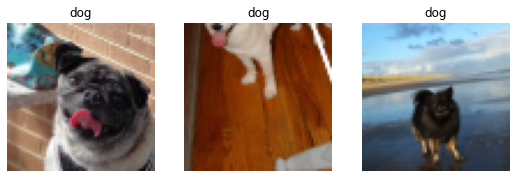

In [7]:
dls_species = get_dls(label_func)
dls_species.show_batch(max_n=3)

It's crucial that these dataloaders show the same images in their training and test sets.  If they don't, we would likely have a data leakage issue where each model has some of the others validation set in them.  This would be really problematic as we will be combining these models together at the end.

Lets add some quick tests to make sure that the valid imgs and the train images are the same.

In [8]:
breed_val = pd.DataFrame(dls_breed.valid.items,columns=['breed_imgs']).sort_values('breed_imgs')
species_val = pd.DataFrame(dls_species.valid.items,columns=['species_imgs']).sort_values('species_imgs')
assert (breed_val.breed_imgs==species_val.species_imgs).all()

In [9]:
breed_train = pd.DataFrame(dls_breed.train.items,columns=['breed_imgs']).sort_values('breed_imgs')
species_train = pd.DataFrame(dls_species.train.items,columns=['species_imgs']).sort_values('species_imgs')
assert (breed_train.breed_imgs==species_train.species_imgs).all()

# The Architecture

Now that we have our data let's talk about what we are going to be testing.

Put simply:  We are creating **resnet architectures** with **more than 1 body**.  We are going to do several variations so we want a flexible wayt to create this.  Let's look at our model class.

I will explain what is going on in it below, as this is central to the whole expirament.
+ **body_list:**  Body list takes a list of encoders (encoder_list) and cuts the heads off.  So now we have a list of bodys using whatever encoders and wieghts were passed, and can do an arbitrary number of bodys using the same class.
+ **self.head:**  This cretes a head that can take all the bodies and combine them.  You will wee that the inputs to the head is dependent on the number of resnet bodies we have.
+ **self.split:**  This just breaks out each body + head into their own parameter groups. This is important so it is easy to freeze the head that is random weights to train that first. 
+ **forward:**  In the forward you see how it is used.  We start by passing the x (image) into each of the bodys and contatenating it together.  That then is passed to the head.  Exactly what we want!

>Note: If any of this doesn't make sense to you, I recommend reading [Chapter 15 of the Deep Learning with Fastai and Pytorch book](https://github.com/fastai/fastbook/blob/master/15_arch_details.ipynb).  That chapter has all the concepts needed to understand what's going on here.

In [ ]:
class PetsModel(Module):
    def __init__(self, encoder_list,vocab):
        self.body_list = [encoder[:-1] for encoder in encoder_list]
        self.head = create_head(512*len(self.body_list)*2,len(vocab))
        self.split = [params(body) for body in self.body_list] + [params(self.head)]
    
    def layer_splitter(self,model):
        return self.split
    
    def forward(self, x):
        # concatenate the outputs of the cut species and cut breed models together
        ftrs = torch.cat([body(x) for body in self.body_list], dim=1)
        
        # Feed the concatenaded outputs to the model head
        return self.head(ftrs)

# The Experiment

Now that we understand this custom architecture, let's go over what all the variations we want to compare.

1. **resnet18, resnet34, resnet50:**  If this custom architecture isn't better than one of these in some way (speed to train, validation accuracy, etc), then we may as well just use a resnet.  So we need to include those for comparison.
1. **2UntrainedBodies, 3UntrainedBodies:**
    + Uses 2 or 3 bodies respectively
    + Bodys are each resnet18
    + Uses pretrained weights with no seperate training
1. **2TrainedBodies, 3TrainedBodies:**
    + Uses 2 or 3 bodies respectively
    + Bodys are each resnet18
    + Takes pretrained resnet18's and seperately trains them on the task first  
1. **2TrainedDupeBodies,3TrainedDupeBodies:**
    + Uses 2 or 3 bodies respectively
    + Bodys are each resnet18
    + Takes pretrained resnet18, train it first, then have bodys duplicates of the trained model
1. **2HeirarchyBodies:**
    + Uses 2 bodys
    + Bodys are each resnet18
    + Body1 is a resnet18 trained to predict species (higher level in heirarchy)
    + Body2 is a resnet18 trained to predict breed (lower level in heirarchy)


# The Results

I will be graphing some key findings to look at, and only graphing the best models.

In [243]:
#hide
def get_dfs(fname):
    with open(fname, 'rb') as f:
        results = pickle.load(f)

    dfs = []
    for exp_name in results.keys():
        tmp = pd.DataFrame(results[exp_name])
        for row in range(len(tmp)):
            if type(tmp.iloc[row,3]) != float:
                tmp.iloc[row,3] = int(tmp.iloc[row,3][:2])*60 + int(tmp.iloc[row,3][-2:])
        tmp.iloc[:,3] = tmp.iloc[:,3].astype(int).cumsum()
        tmp[1] = [min(10,o) for o in tmp[1]]
        tmp.loc[tmp[1]==10,1] = np.nan


        df = tmp
        df.reset_index(drop=True,inplace=True)
        dfs.append(df)
    return dfs

In [206]:
#hide
dfs = get_dfs('ts2021-01-18 17:28:22.315808-cp148.pkl')

Let's start with with a review of the 3 best models:
+ `2UnTrainedBodies`: Had 2 `resnet18` bodies, both using pytorch pretrained model weights.
+ `3UnTrainedBodies`: Had 3 `resnet18` bodies, each using pytorch pretrained model weights.
+ `2TrainedDupeBodies`: Fine tuned 1 `resnet18`, then used the weights from that model for both bodies

Let's start by looking at validation accuracy.  Key notes:
+ This looks at the best 3 models only
+ We can see that our best model models are between a resnet 34 and resnet 50 in terms of accuracy consistently in the last 20 epochs
+ Based on these results, there isn't really any value in training the bodies seperately before combining them.  It's more beneficial to train the system as a whole immediately.

In [208]:
#hide
def plot_results(metric,models,ylim=None,xlim=None):
    fig, ax = plt.subplots(1,1,figsize=(16,8))
    metrics = ['Train Loss','Validation Loss','Validation Accuracy','Cumulative Train Time']
    col_idx = int([i for i, s in enumerate(metrics) if metric in s][0])
    for j in models:
        col = dfs[j].columns[col_idx]
        ax.plot(dfs[j][col], label=L(results.keys())[j])    
    ax.legend()
    ax.set_xlabel('epoch')    
    ax.set_ylabel(metric)
    ax.set_title(metric)
    if ylim: ax.set_ylim(*ylim)
    if xlim: ax.set_xlim(*xlim)

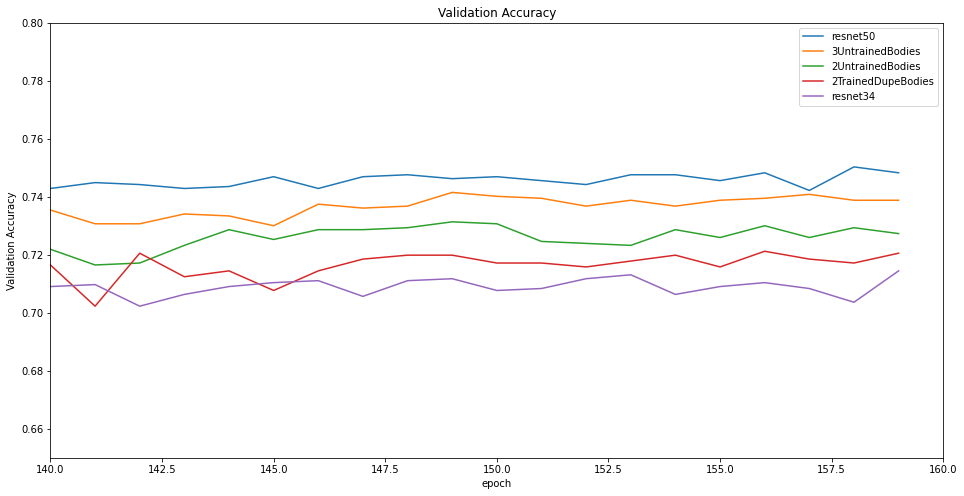

In [258]:
#hide_input
plot_results('Validation Accuracy',[1,6,5,8,0],(0.65,0.8),(140,160));

Now the graph above does a great job of showing the consistency in the final epochs, but it does hide some of the early training instability.  Here's a fuller view

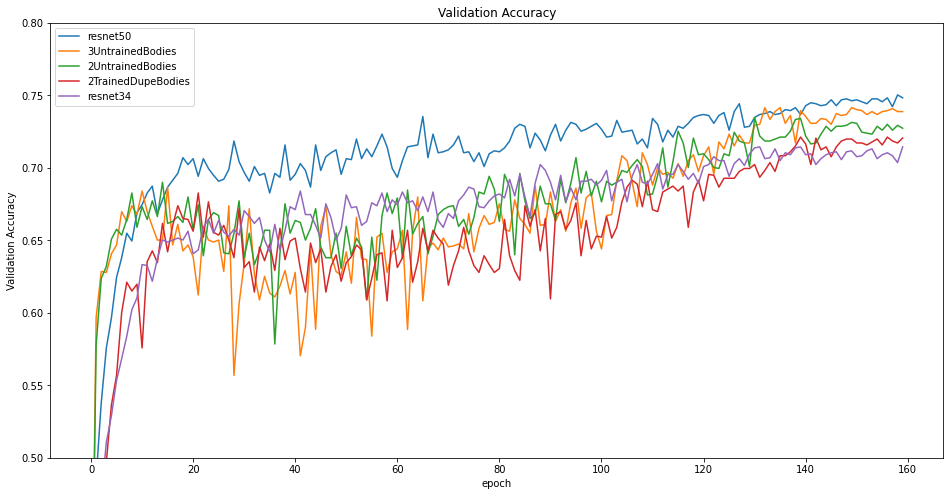

In [260]:
#hide_input
plot_results('Validation Accuracy',[1,6,5,8,0],ylim=(0.5,0.8));

Great!  So this seems really promising.  But the real question now is why use this approach over a `resnet50`?  To do that let's look at the time to process (below).

Below we see a few things:
+ The `resnet50` (which was the most accurate) takes the longest to train
+ The `resnet34` takes **slightly** more time to train as the `2TrainedDupeBodies` and the `2UntrainedBodies` model, even though the `resnet34` is less accurate.
+ The `3UntrainedBodies` model is not quite as accurate as the `resnet50` but also doesn't take as long to train.

>Note: This is really important because 2 of the custom architectures have a better accuracy and trains in the slightly less time than a `resnet34`. That's great news!

We will look at a zoomed in view so the differentiations are clearer.  Please be aware the Y axis does not start at 0.

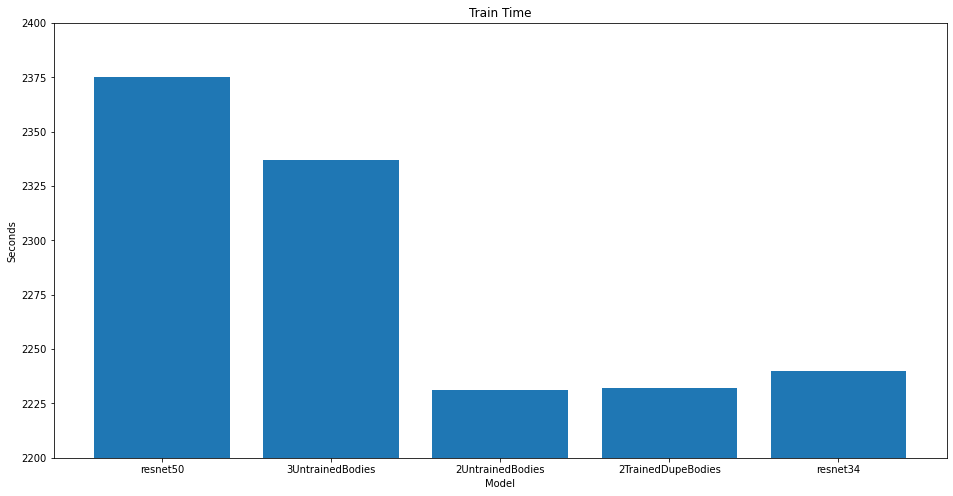

In [242]:
#hide_input
models=[1,6,5,8,0]
fig, ax = plt.subplots(1,1,figsize=(16,8))      
labels = L(results.keys())[models]
values = [max(df[3]) for df in L(dfs)[models]]
ax.bar(labels,values)
ax.set_xlabel('Model')    
ax.set_ylabel('Seconds')
ax.set_title('Train Time')
ax.set_ylim(2200,2400)
plt.show()